CNN TUBERKULOSIS (TRAIN VAL TEST)

BELUM DI RUN
# New section

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls "../content/drive/MyDrive/Colab Notebooks/Dataset/xray-tb-3"

'70 10 20.txt'	 test   train   val


In [ ]:
!pip install matplotlib-venn

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
from keras.utils import to_categorical
from keras.models import Model
from keras.layers import Input, Conv2D, Dense, Dropout, MaxPool2D, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator # Changed the import path to use tensorflow.keras.preprocessing.image
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

In [ ]:
def load_images(image_path):
    files = np.array(os.listdir(image_path))

    images = []
    for image in tqdm(files):
        # Read image
        img_path = os.path.join(image_path, image) # Create the full image path using os.path.join to avoid potential path issues
        image = cv2.imread(img_path)

        if image is not None: # Check if the image was loaded correctly
            # Resize image to 224x224 px
            image = cv2.resize(image, (224,224), interpolation=cv2.INTER_AREA)
            images.append(image)
        else:
            print(f"Failed to load image: {img_path}") # Print an error message if the image cannot be loaded

    images = np.array(images)

    return images

In [ ]:
# Fungsi load_images untuk memuat gambar dari direktori (asumsi ini mengembalikan list/array)
normal_train = load_images('../content/drive/MyDrive/Colab Notebooks/Dataset/xray-tb-3/train/normal')
aktif_train = load_images('../content/drive/MyDrive/Colab Notebooks/Dataset/xray-tb-3/train/aktif')
laten_train = load_images('../content/drive/MyDrive/Colab Notebooks/Dataset/xray-tb-3/train/laten')

normal_val = load_images('../content/drive/MyDrive/Colab Notebooks/Dataset/xray-tb-3/val/normal')
aktif_val  = load_images('../content/drive/MyDrive/Colab Notebooks/Dataset/xray-tb-3/val/aktif')
laten_val  = load_images('../content/drive/MyDrive/Colab Notebooks/Dataset/xray-tb-3/val/laten')

normal_test = load_images('../content/drive/MyDrive/Colab Notebooks/Dataset/xray-tb-3/test/normal')
aktif_test = load_images('../content/drive/MyDrive/Colab Notebooks/Dataset/xray-tb-3/test/aktif')
laten_test = load_images('../content/drive/MyDrive/Colab Notebooks/Dataset/xray-tb-3/test/laten')

100%|██████████| 300/300 [00:16<00:00, 18.59it/s] 


In [ ]:
# Label numerik
laten_labels = [2] * len(laten_train)
aktif_labels = [1] * len(aktif_train)
normal_labels = [0] * len(normal_train)

laten_test_labels = [2] * len(laten_test)
aktif_test_labels = [1] * len(aktif_test)
normal_test_labels = [0] * len(normal_test)

laten_val_labels = [2] * len(laten_val)
aktif_val_labels = [1] * len(aktif_val)
normal_val_labels = [0] * len(normal_val)

In [ ]:
# Gabungkan data TRAIN
X_train = np.concatenate((normal_train, aktif_train, laten_train), axis=0)
y_train = np.array(normal_labels + aktif_labels + laten_labels)
X_train, y_train = shuffle(X_train, y_train, random_state=42)

# Gabungkan data VALIDASI
X_val = np.concatenate((normal_val, aktif_val, laten_val), axis=0)
y_val = np.array(normal_val_labels + aktif_val_labels + laten_val_labels)
X_val, y_val = shuffle(X_val, y_val, random_state=42)

# Gabungkan data TEST
X_test = np.concatenate((normal_test, aktif_test, laten_test), axis=0)
y_test = np.array(normal_test_labels + aktif_test_labels + laten_test_labels)
X_test, y_test = shuffle(X_test, y_test, random_state=42)

In [ ]:
# Normalisasi citra ke 0–1
X_train = X_train / 255.0
X_val   = X_val / 255.0
X_test  = X_test / 255.0

In [ ]:
# One-hot encoding label
y_train = to_categorical(y_train, num_classes=3)
y_val   = to_categorical(y_val, num_classes=3)
y_test  = to_categorical(y_test, num_classes=3)

In [ ]:
# Input layer, ukuran citra 224x224 dengan 3 channel warna (RGB)
input_layer = Input(shape=(224, 224, 3))

# Convolutional layer pertama dengan 16 filter, ukuran kernel 3x3, padding 'same', dan aktivasi ReLU
cnn = Conv2D(16, (3, 3), activation='relu', padding='same')(input_layer)

# Max pooling layer dengan ukuran pool 2x2
cnn = MaxPool2D((2, 2))(cnn)

# Convolutional layer kedua dengan 32 filter, ukuran kernel 3x3, padding 'same', dan aktivasi ReLU
cnn = Conv2D(32, (3, 3), activation='relu', padding='same')(cnn)

# Max pooling layer kedua dengan ukuran pool 2x2
cnn = MaxPool2D((2, 2))(cnn)

# Convolutional layer ketiga dengan 64 filter, ukuran kernel 3x3, padding 'same', dan aktivasi ReLU
cnn = Conv2D(64, (3, 3), activation='relu', padding='same')(cnn)

# Max pooling layer ketiga dengan ukuran pool 2x2
cnn = MaxPool2D((2, 2))(cnn)

# Flatten layer untuk meratakan output dari layer sebelumnya menjadi vektor satu dimensi
cnn = Flatten()(cnn)

# Dropout layer dengan rate 0.5 untuk mencegah overfitting
cnn = Dropout(0.5)(cnn)

# Fully connected (Dense) layer dengan 128 neuron dan aktivasi ReLU
cnn = Dense(128, activation='relu')(cnn)

# Dropout layer kedua dengan rate 0.5 untuk mencegah overfitting
cnn = Dropout(0.5)(cnn)

# Output layer dengan 3 neuron (untuk 3 kelas) dan aktivasi Softmax untuk klasifikasi multi-kelas
output_layer = Dense(3, activation='softmax')(cnn)

# Membuat model dengan input dan output layer
model = Model(inputs=input_layer, outputs=output_layer)

In [ ]:
# Mengompilasi model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:
datagen = ImageDataGenerator(
    rotation_range=5,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

# Fit data augmentation pada data training
datagen.fit(X_train)

In [ ]:
# Callback untuk menyimpan model terbaik
checkpoint = ModelCheckpoint(
    'model_multiclass.keras',
    monitor='val_accuracy',
    mode='max',
    verbose=1,
    save_best_only=True
)

# Training model
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    epochs=150,
    validation_data=(X_val, y_val),
    callbacks=[checkpoint],
    shuffle=True
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/150
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step - accuracy: 0.4538 - loss: 1.1903
Epoch 1: val_accuracy improved from -inf to 0.48444, saving model to model_multiclass.keras
99/99 ━━━━━━━━━━━━━━━━━━━━ 46s 387ms/step - accuracy: 0.4545 - loss: 1.1882 - val_accuracy: 0.4844 - val_loss: 1.0043
Epoch 2/150
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - accuracy: 0.5956 - loss: 0.8435
Epoch 2: val_accuracy improved from 0.48444 to 0.64444, saving model to model_multiclass.keras
99/99 ━━━━━━━━━━━━━━━━━━━━ 32s 325ms/step - accuracy: 0.5957 - loss: 0.8434 - val_accuracy: 0.6444 - val_loss: 0.7996
Epoch 3/150
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step - accuracy: 0.6592 - loss: 0.7576
Epoch 3: val_accuracy did not improve from 0.64444
99/99 ━━━━━━━━━━━━━━━━━━━━ 42s 335ms/step - accuracy: 0.6593 - loss: 0.7574 - val_accuracy: 0.5711 - val_loss: 0.8686
Epoch 4/150
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - accuracy: 0.6791 - loss: 0.7121
Epoch 4: val_accuracy did not improve from 0.64444
99/99 ━━━

In [ ]:
# Simpan model ke dalam drive
model.save('../content/drive/MyDrive/Colab Notebooks/Dataset/14-june-CNN_3_70-10-20_pt2.keras')

In [ ]:
# Evaluasi model
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


Test Loss: 1.0426
Test Accuracy: 0.8000


In [ ]:
# Evaluasi model
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


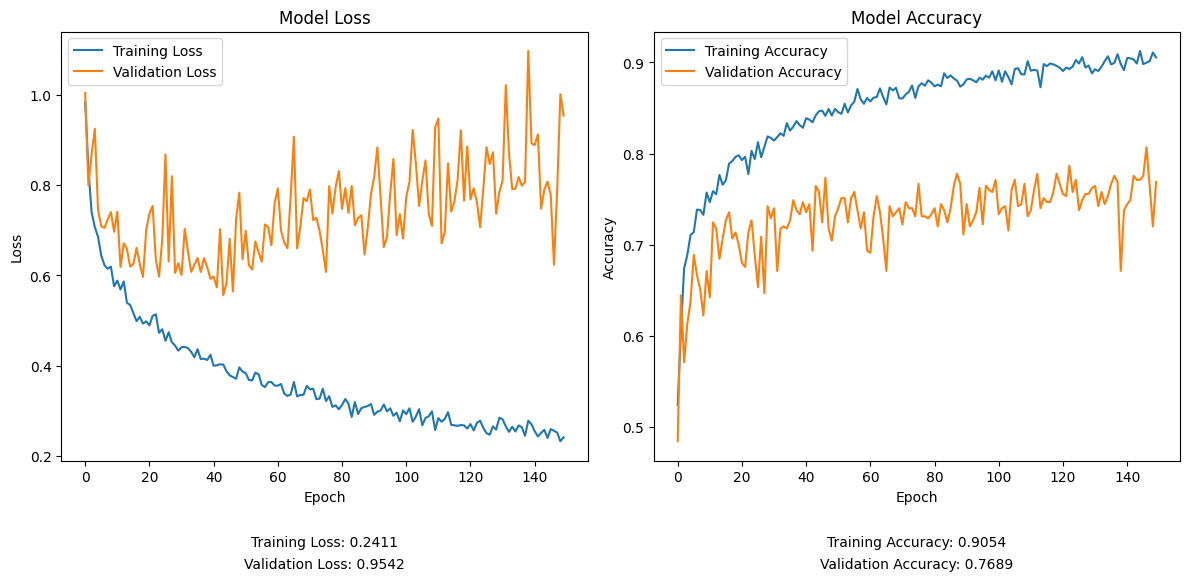

In [ ]:
# Membuat subplots dengan 1 baris dan 2 kolom
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Visualisasi Loss
axes[0].plot(history.history['loss'], label='Training Loss')
axes[0].plot(history.history['val_loss'], label='Validation Loss')
axes[0].set_title('Model Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')

# Menampilkan nilai terakhir loss di bawah grafik
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]
axes[0].text(0.5, -0.2, f'Training Loss: {final_train_loss:.4f}', fontsize=10, ha='center', transform=axes[0].transAxes)
axes[0].text(0.5, -0.25, f'Validation Loss: {final_val_loss:.4f}', fontsize=10, ha='center', transform=axes[0].transAxes)

# Visualisasi Accuracy
axes[1].plot(history.history['accuracy'], label='Training Accuracy')
axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[1].set_title('Model Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')

# Menampilkan nilai terakhir accuracy di bawah grafik
final_train_accuracy = history.history['accuracy'][-1]
final_val_accuracy = history.history['val_accuracy'][-1]
axes[1].text(0.5, -0.2, f'Training Accuracy: {final_train_accuracy:.4f}', fontsize=10, ha='center', transform=axes[1].transAxes)
axes[1].text(0.5, -0.25, f'Validation Accuracy: {final_val_accuracy:.4f}', fontsize=10, ha='center', transform=axes[1].transAxes)

# Menambahkan legend ke kedua grafik
axes[0].legend()
axes[1].legend()

# Menampilkan plot
plt.tight_layout()  # Untuk mengatur jarak antar grafik
plt.show()


29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step


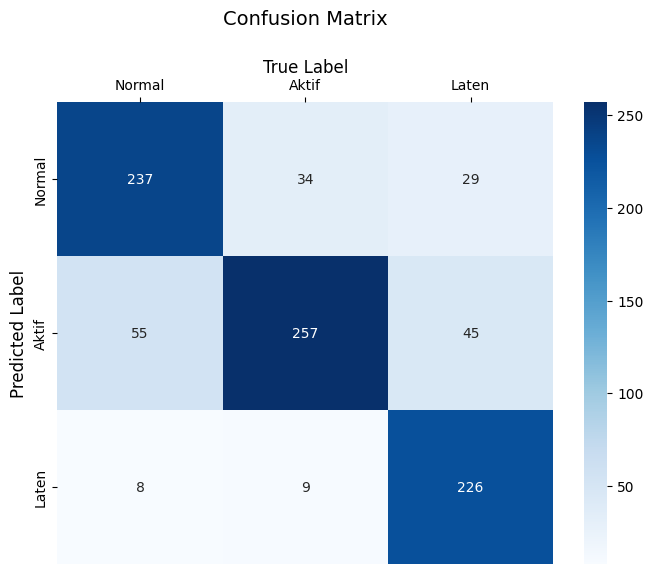

Accuracy:  0.8000
Precision: 0.8133
Recall:    0.8000
F1 Score:  0.8016

Classification Report:
              precision    recall  f1-score   support

      Normal       0.79      0.79      0.79       300
       Aktif       0.72      0.86      0.78       300
       Laten       0.93      0.75      0.83       300

    accuracy                           0.80       900
   macro avg       0.81      0.80      0.80       900
weighted avg       0.81      0.80      0.80       900



In [ ]:
# Mengambil label asli dari one-hot encoding
y_true = np.argmax(y_test, axis=1)

# Mendapatkan prediksi dari model pada data test
y_pred = model.predict(X_test)

# Mengambil kelas dengan probabilitas tertinggi sebagai prediksi kelas
y_pred_classes = np.argmax(y_pred, axis=1)

# Confusion matrix (dibalik: baris = prediksi, kolom = label asli)
cm = confusion_matrix(y_pred_classes, y_true)
class_names = ['Normal', 'Aktif', 'Laten']  # Sesuaikan jika perlu

plt.figure(figsize=(8,6))
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                 xticklabels=class_names, yticklabels=class_names)

# Pindahkan label x ke atas
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')
plt.xlabel('True Label', fontsize=12)
plt.ylabel('Predicted Label', fontsize=12)
plt.title('Confusion Matrix\n', pad=40, fontsize=14)  # Beri jarak agar tidak numpuk

plt.show()

# Import necessary metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Evaluasi metrik
print(f"Accuracy:  {accuracy_score(y_true, y_pred_classes):.4f}")
print(f"Precision: {precision_score(y_true, y_pred_classes, average='macro'):.4f}")
print(f"Recall:    {recall_score(y_true, y_pred_classes, average='macro'):.4f}")
print(f"F1 Score:  {f1_score(y_true, y_pred_classes, average='macro'):.4f}")

print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))

In [ ]:
y_pred_classes = np.argmax(y_pred, axis=1)  # Mengambil kelas dengan probabilitas tertinggi

# Nama kelas untuk multi-kelas
class_names = ['Normal', 'Aktif', 'Laten']

# Evaluasi metrik
print(f"Accuracy:  {accuracy_score(y_true, y_pred_classes):.4f}")
print(f"Precision: {precision_score(y_true, y_pred_classes, average='macro'):.4f}")
print(f"Recall:    {recall_score(y_true, y_pred_classes, average='macro'):.4f}")
print(f"F1 Score:  {f1_score(y_true, y_pred_classes, average='macro'):.4f}")

print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))

Accuracy:  0.8000
Precision: 0.8133
Recall:    0.8000
F1 Score:  0.8016

Classification Report:
              precision    recall  f1-score   support

      Normal       0.79      0.79      0.79       300
       Aktif       0.72      0.86      0.78       300
       Laten       0.93      0.75      0.83       300

    accuracy                           0.80       900
   macro avg       0.81      0.80      0.80       900
weighted avg       0.81      0.80      0.80       900



# LOAD MODEL

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install matplotlib-venn

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
from keras.utils import to_categorical
from keras.models import Model
from keras.layers import Input, Conv2D, Dense, Dropout, MaxPool2D, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator # Changed the import path to use tensorflow.keras.preprocessing.image
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

In [ ]:
#Load model sesuai skenario
model = load_model('../content/drive/MyDrive/Colab Notebooks/Dataset/14-june-CNN_3_70-10-20_pt2.keras')

In [ ]:
def load_images_with_label(image_path, label):
    files = sorted(os.listdir(image_path))  # Supaya konsisten urutannya
    images = []
    labels = []
    filenames = []

    for image_name in tqdm(files, desc=f"Loading {os.path.basename(image_path)}"):
        img_path = os.path.join(image_path, image_name)
        image = cv2.imread(img_path)

        if image is not None:
            image = cv2.resize(image, (224, 224), interpolation=cv2.INTER_AREA)
            images.append(image)
            labels.append(label)
            filenames.append(image_name)
        else:
            print(f"Failed to load image: {img_path}")

    return np.array(images), np.array(labels), filenames


In [ ]:
# Load test set per kelas
normal_imgs, normal_labels, normal_filenames = load_images_with_label(
    '../content/drive/MyDrive/Colab Notebooks/Dataset/xray-tb-3/test/normal', label=0)

aktif_imgs, aktif_labels, aktif_filenames = load_images_with_label(
    '../content/drive/MyDrive/Colab Notebooks/Dataset/xray-tb-3/test/aktif', label=1)

laten_imgs, laten_labels, laten_filenames = load_images_with_label(
    '../content/drive/MyDrive/Colab Notebooks/Dataset/xray-tb-3/test/laten', label=2)

Loading laten: 100%|██████████| 300/300 [00:08<00:00, 36.94it/s]


In [ ]:
# Gabungkan semua data test
X_test = np.concatenate((normal_imgs, aktif_imgs, laten_imgs), axis=0)
y_test = np.concatenate((normal_labels, aktif_labels, laten_labels), axis=0)
filenames_test = normal_filenames + aktif_filenames + laten_filenames

# Acak agar distribusinya campur
X_test, y_test, filenames_test = shuffle(X_test, y_test, filenames_test, random_state=42)


In [ ]:
X_test  = X_test / 255.0

y_test  = to_categorical(y_test, num_classes=3)

In [ ]:
predicted_probs = model.predict(X_test)
predicted_classes = np.argmax(predicted_probs, axis=1)
confidences = np.max(predicted_probs, axis=1)

29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step


In [ ]:
y_test_labels = np.argmax(y_test, axis=1)

In [ ]:
import pandas as pd

class_names = ['Normal', 'Aktif', 'Laten']

df_results = pd.DataFrame({
    "Filename": filenames_test,
    "True Label": [class_names[i] for i in y_test_labels],
    "Predicted Label": [class_names[i] for i in predicted_classes],
    "Confidence": confidences * 100,
    "Status": ["Benar" if y_true == y_pred else "Salah"
               for y_true, y_pred in zip(y_test_labels, predicted_classes)]
})

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step


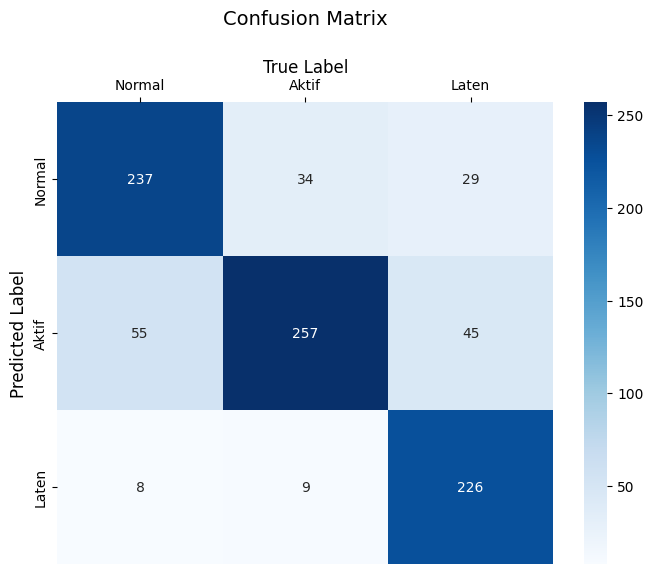

Accuracy:  0.8000
Precision: 0.8133
Recall:    0.8000
F1 Score:  0.8016

Classification Report:
              precision    recall  f1-score   support

      Normal       0.79      0.79      0.79       300
       Aktif       0.72      0.86      0.78       300
       Laten       0.93      0.75      0.83       300

    accuracy                           0.80       900
   macro avg       0.81      0.80      0.80       900
weighted avg       0.81      0.80      0.80       900



In [ ]:
# Mengambil label asli dari one-hot encoding
y_true = np.argmax(y_test, axis=1)

# Mendapatkan prediksi dari model pada data test
y_pred = model.predict(X_test)

# Mengambil kelas dengan probabilitas tertinggi sebagai prediksi kelas
y_pred_classes = np.argmax(y_pred, axis=1)

# Confusion matrix (dibalik: baris = prediksi, kolom = label asli)
cm = confusion_matrix(y_pred_classes, y_true)
class_names = ['Normal', 'Aktif', 'Laten']  # Sesuaikan jika perlu

plt.figure(figsize=(8,6))
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                 xticklabels=class_names, yticklabels=class_names)

# Pindahkan label x ke atas
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')
plt.xlabel('True Label', fontsize=12)
plt.ylabel('Predicted Label', fontsize=12)
plt.title('Confusion Matrix\n', pad=40, fontsize=14)  # Beri jarak agar tidak numpuk

plt.show()

# Import necessary metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Evaluasi metrik
print(f"Accuracy:  {accuracy_score(y_true, y_pred_classes):.4f}")
print(f"Precision: {precision_score(y_true, y_pred_classes, average='macro'):.4f}")
print(f"Recall:    {recall_score(y_true, y_pred_classes, average='macro'):.4f}")
print(f"F1 Score:  {f1_score(y_true, y_pred_classes, average='macro'):.4f}")

print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def show_prediction_grid(images, filenames, true_labels, pred_labels, class_names, n=25):
    plt.figure(figsize=(12, 12))
    indices = np.random.choice(len(images), size=n, replace=False)
    ##indices = list(range(n))  # Ambil 25 pertama
    rows = cols = int(np.ceil(np.sqrt(n)))

    for i, idx in enumerate(indices):
        img = images[idx]
        true = true_labels[idx]
        pred = pred_labels[idx]
        filename = filenames[idx]

        color = 'green' if true == pred else 'red'
        title = f"{filename}\nTrue: {class_names[true]}\nPred: {class_names[pred]}"

        plt.subplot(rows, cols, i + 1)
        plt.imshow(img.astype(np.uint8))  # Pastikan gambar dalam format uint8
        plt.axis('off')
        plt.title(title, fontsize=8, color=color)

    plt.tight_layout()
    plt.show()


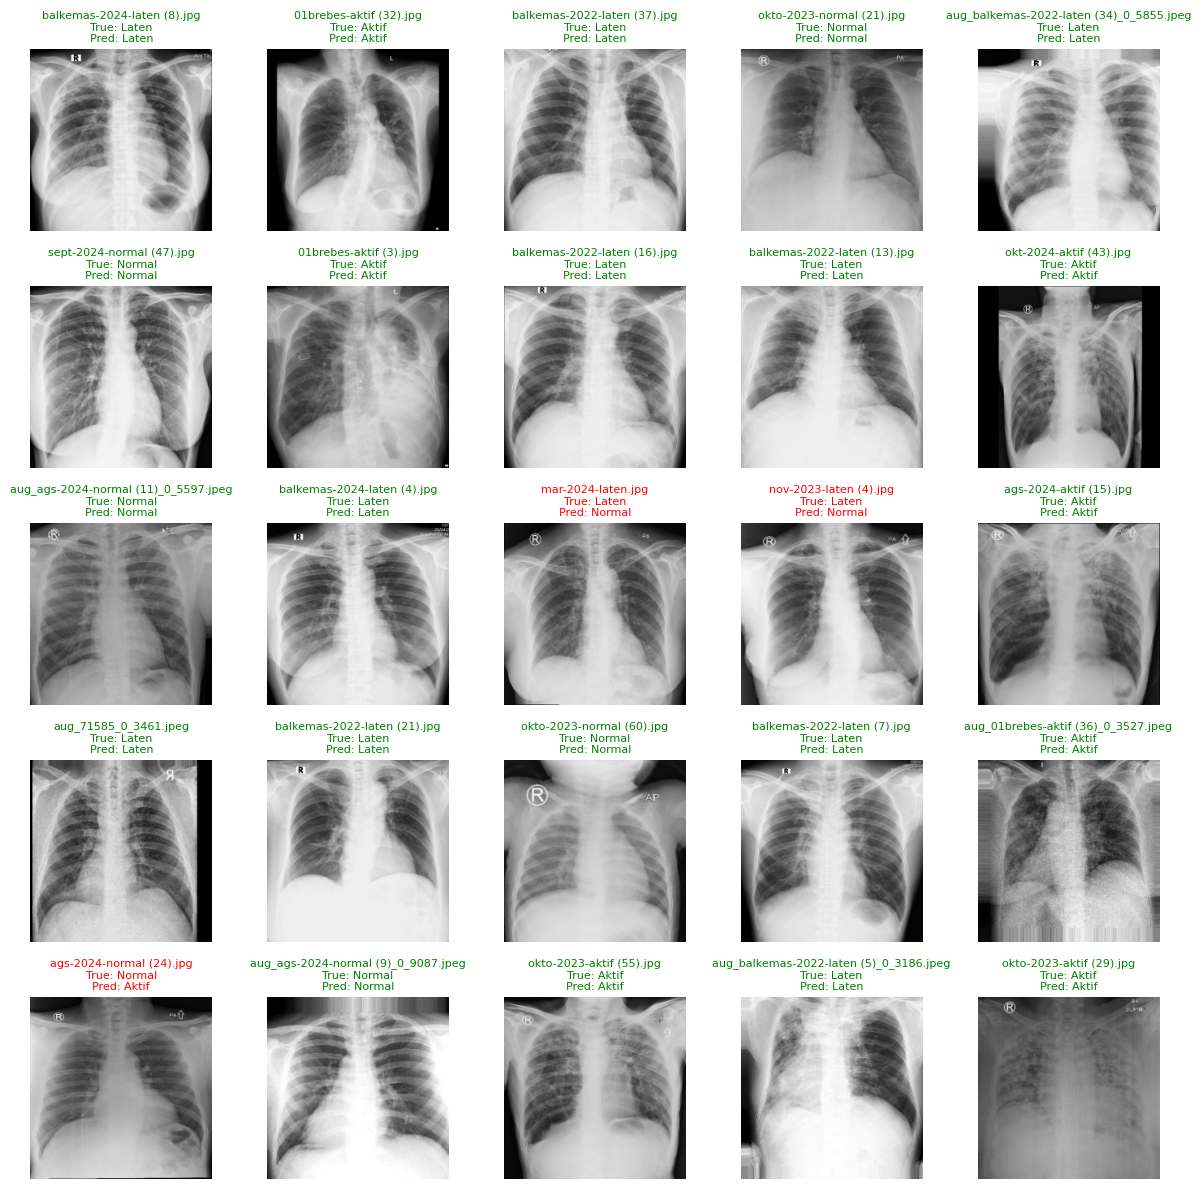

In [ ]:
show_prediction_grid(
    images=(X_test * 255).astype(np.uint8),  # Balikkan ke uint8 untuk ditampilkan
    filenames=filenames_test,
    true_labels=y_test_labels,
    pred_labels=predicted_classes,
    class_names=['Normal', 'Aktif', 'Laten'],
    n=25  # jumlah gambar ditampilkan (maks 25 ideal)
    #start=25,
    #n=25
)


Simpan xlsx

In [ ]:
label_order = ['Normal', 'Aktif', 'Laten']

# 2. Ubah kolom 'True Label' menjadi tipe kategori berurutan
df_results['True Label'] = pd.Categorical(
    df_results['True Label'],
    categories=label_order,
    ordered=True
)

# 3. Sort berdasarkan 'True Label' dan 'Filename'
df_results_sorted = df_results.sort_values(by=['True Label', 'Filename'], ascending=[True, True])

# 4. Simpan ke Excel dan CSV
save_dir = '../content/drive/MyDrive/Colab Notebooks/Dataset/'
filename_excel = save_dir + 'CNN-70-10-20.xlsx'
filename_csv = save_dir + 'CNN-70-20-20.csv'

df_results_sorted.to_excel(filename_excel, index=False)
df_results_sorted.to_csv(filename_csv, index=False)

# 5. Info hasil
print("Filenyaa Sudah disimpan disini:")
print(f"- Excel: {filename_excel}")
print(f"- CSV  : {filename_csv}")


Filenyaa Sudah disimpan disini:
- Excel: ../content/drive/MyDrive/Colab Notebooks/Dataset/CNN-70-10-20.xlsx
- CSV  : ../content/drive/MyDrive/Colab Notebooks/Dataset/CNN-70-20-20.csv
